## 1. Install libraries
First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [ ]:
#!conda install -n .conda ipykernel --update-deps --force-reinstall
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#%pip install -r requirements.txt

  Cloning https://github.com/AllStarsAT/starvers.git to c:\users\dell\appdata\local\temp\pip-install-fqjm528r\starvers_cbc21f6f50da48869d049e77c242dfa6
  Resolved https://github.com/AllStarsAT/starvers.git to commit 5e6e112e2b37cb5a27af9585bd572d27187ef735
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached cycler

  Running command git clone --filter=blob:none --quiet https://github.com/AllStarsAT/starvers.git 'C:\Users\Dell\AppData\Local\Temp\pip-install-fqjm528r\starvers_cbc21f6f50da48869d049e77c242dfa6'


In [1]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine
import uuid
import seaborn as sns


## 2. Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [2]:
executed_by ='stud-id_12307565'
#executed_by = 'stud-id_12340246'   

Set your group and student IDs. Do this only once.

In [3]:
# group id for this project
group_id = '009'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12307565'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12340246'  # Replace the digits after "id_" with student B's student ID

In [4]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [5]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

In [6]:
# For a consistent connection to server

import time
time.tzname = ('Europe/Vienna', 'Europe/Vienna')

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [7]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [8]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [9]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Liliana" .',
f':{student_a} foaf:familyName "Sulyok" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12307565"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Zita Dorina" .',
f':{student_b} foaf:familyName "Marton" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12340246"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


# engine.insert(reigstration_triples_a, prefixes=prefixes)
# engine.insert(reigstration_triples_b, prefixes=prefixes)
# engine.insert(role_triples, prefixes=prefixes)

In [10]:
# UUIDs will be generated for each data processing step, and entered manually

str(uuid.uuid4())

'20ece7dd-0a22-4faa-a713-f216e8371e94'

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

## 3. Business Understanding 

In [11]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
# engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [13]:
data_src_and_scenario_comment = """
The dataset is the Online Shoppers Purchasing Intention Dataset from the 
UCI Machine Learning Repository. It contains 12,330 anonymized, unique user
sessions from an e-commerce website collected over one year. The detaset 
includes behavioral, technical, and user-related attributes such as page
duration, bounce rates, visitor type. The binary target variable indicates 
whether a session resulted in revenue. 

Business Scenario:
We assume the role of data scientists for a mid-sized online retail company
that seeks to improve its marketing efficiency by identifing sessions with high
purchase intent in real time. This allows the marketing team to apply targeted
interventions (such as live chat support or limited-time discount pop-ups 
specifically for users likely to purchase) only when beneficial. 
Predicting purchase likelihood enables cost-efficient personalization, 
optimizing marketing resources and strategic decision-making
"""

business_objectives_comment = """
Primary Objective:
Increase online revenue by identifying sessions with high purchase intent and 
by proactively engaging customers using targeted, cost-efficient interventions 
that increase the probability of conversion.

Secondary Objectives:
Improve the overall conversion rate through real-time personalization.
Reduce unnecessary promotional costs on users who are highly unlikely to buy
regardless of incentives.
"""

business_success_criteria_comment = """
The project is considered a success if the resulting model can be deployed to:

Profitability: Identify purchasing customers with sufficient precision that the 
cost of the intervention (e.g., the discount margin lost) is outweighed by the 
revenue gained from "saved" sales.

Deployment Feasibility: The model must be lightweight enough to infer intent in
near real-time (milliseconds) as the user browses.
"""

data_mining_goals_comment = """
Primary Data Mining Goal: Binary Classification
Develop a supervised machine learning model to predict the target variable 
Revenue and estimates the likelihood that a given web session will result in 
a purchase.


Secondary Goal: Imbalance Management
The dataset is imbalanced (approx. 85% negative / 15% positive), therefore the
goal is to handle this skew effectively without biasing the model toward the 
majority class (No Purchase).
"""

data_mining_success_criteria_comment = """
Model-level performance targets

AUC-ROC Score: 
Achieving a score greater than 0.80 on the test set, indicating a strong 
ability to distinguish between buyers and non-buyers.

F1-Score: 
Achieving a score greater than 0.50, which is the current state-of-the-art
baseline result.

Baseline Comparison:
The model must significantly outperform a trivial classifier (which would 
achieve ~85% accuracy by always predicting "No Purchase") and a random guess 
baseline.

Stable performance across validation splits.
"""

ai_risk_aspects_comment = """
Key AI risk considerations:

1. Bias and Fairness:
The dataset contains features such as browser, operating system, and region, 
which may act as proxies for socioeconomic status, potentially leading to unfair
treatment across user groups. Class imbalance may also bias predictions towards 
the majority class.

2. Privacy and Profiling:
The analysis uses tracking data (Operating Systems, Browser, Duration). 
Deployment requires strict adherence to privacy regulations (e.g., GDPR), 
ensuring users have consented to behavioral tracking, knowing that bhavioral 
data may enable profiling of users.

3. Transparency:
If personalized offers are triggered based on model predictions, stakeholders 
must be able to understand and justify the reasoning behind these decisions.

4. Operational Risk:
Incorrect predictions may lead to unnecessary promotion costs (false positives)
or missed revenue opportunities (false negatives). 
Thresholding and monitoring must be carefully designed.

5. Manipulation:
There is an ethical risk in exploiting behavioral data to target vulnerable
users with aggressive sales tactics.
"""



business_understanding_uuid_executor = '53996d94-9b75-4479-9046-e15a53067259' #generated, do not modify
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .',
f':business_understanding prov:qualifiedAssociation :{business_understanding_uuid_executor} .',
f':{business_understanding_uuid_executor} prov:agent :{executed_by} .',
f':{business_understanding_uuid_executor} rdf:type prov:Association .',
f':{business_understanding_uuid_executor} prov:hadRole :{code_executor_role} .',
]
# engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
# engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

### Load data

In [14]:
## Each Activity that follows is part of the Data Understanding Phase

data_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
# engine.insert(data_understanding_phase_executor, prefixes=prefixes)


In [15]:
load_shopping_data_code_writer = student_a

def load_shopping_data(filepath: str)-> pd.DataFrame:
    """
    Load the online shoppers purchasing intention dataset from a CSV file.
    The nature of the data requires no index set.

    Returns:
        pd.DataFrame: DataFrame containing the loaded dataset.
    """
    
    raw_data = pd.read_csv(shopping_data_path,  sep=',', header = 0)
    # Check for invalid month values, and convert to date type
    valid_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    raw_data['Month'] = raw_data['Month'].apply(lambda x: next(
        (month for month in valid_months if month in x), None) 
        if isinstance(x, str) else None)
    raw_data['Month'] = pd.to_datetime(raw_data['Month'], format='%b', 
                                       errors='coerce').dt.month

    # Convert textual categories to numerical categories
    visitor_type_mapping = {
    'Returning_Visitor': 1,
    'New_Visitor': 2,
    'Other': 3
    }

    raw_data['VisitorType'] = raw_data['VisitorType'].map(visitor_type_mapping)
    raw_data['VisitorType'] = raw_data['VisitorType'].fillna(3).astype(int)

    return raw_data



start_time_ld = now()
shopping_data_path = os.path.join("data", "online_shoppers_intention.csv")
shopping_df = load_shopping_data(shopping_data_path)
end_time_ld = now()

display(shopping_df.head())


#############################################
# Documentation
#############################################

ld_ass_uuid_executor = "fa0f4ddf-4a31-40bd-b2a0-98146b8f2de5" #generated, do not modify
load_shopping_data_executor = [
    f':load_shopping_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
# engine.insert(load_shopping_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "8fc07fd5-de82-4b44-a7b7-ecafc0fdbe09" #generated, do not modify
ld_report = """
Load all records of the shopping dataset. The activity reads the CSV file,
converts the Month attribute to a machine-readable textual representation,
converts the Visitor type attribute to numerical categories, and 
returns a dataframe containing 18 semantically interpretable fields.
"""
load_shopping_data_activity = [
    ':load_shopping_data rdf:type prov:Activity .',
    ':load_shopping_data sc:isPartOf :data_understanding_phase .',
    ':load_shopping_data rdfs:comment \'Data Understanding\' .',
    f':load_shopping_data rdfs:comment """{ld_report}""" .', 
    f':load_shopping_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_shopping_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',

    #Writer association
    f':load_shopping_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_shopping_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # INPUT of activity
    ':load_shopping_data prov:used :raw_data .',
    ':load_shopping_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',

    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_shopping_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
# engine.insert(load_shopping_data_activity, prefixes=prefixes)

# Description of the raw data using Croissant
raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name \'Online Shoppers Purchasing Intention Dataset\' .',
    ':raw_data sc:description \'Describe the data set.\' .',

    # The dataset
    ':online_shoppers_intention_csv rdf:type cr:FileObject .',
    ':online_shoppers_intention_csv sc:name \'online_shoppers_intention.csv\' .',
    ':online_shoppers_intention_csv sc:encodingFormat \'text/csv\' .',
    ':raw_data sc:distribution :online_shoppers_intention_csv .',

    # Distribution 
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name \'Table of online shopping sessions over a year\' .',
    ':raw_recordset cr:source :online_shoppers_intention_csv .',
    ':raw_data cr:recordSet :raw_recordset .'
]
# engine.insert(raw_data_triples, prefixes=prefixes)

# Description of all the fields in the dataset using Croissant
fields = {
    "Administrative": ("Number of administrative pages visited.", "xsd:integer"),
    "Administrative_Duration": ("Time spent on administrative pages (sec).", "xsd:double"),
    "Informational": ("Number of informational pages visited.", "xsd:integer"),
    "Informational_Duration": ("Time spent on informational pages (sec).", "xsd:double"),
    "ProductRelated": ("Number of product-related pages viewed.", "xsd:integer"),
    "ProductRelated_Duration": ("Total time on product pages (sec).", "xsd:double"),
    "BounceRates": ("Average bounce rate.", "xsd:double"),
    "ExitRates": ("Average exit rate.", "xsd:double"),
    "PageValues": ("Average value a user visited before completing a transaction.", "xsd:double"),
    "SpecialDay": ("Proximity to a special day (0–1).", "xsd:double"),
    "Month": ("Month of session.", "xsd:string"),
    "OperatingSystems": ("Operating system code.", "xsd:integer"),
    "Browser": ("Browser code.", "xsd:integer"),
    "Region": ("Region code.", "xsd:integer"),
    "TrafficType": ("Traffic source category.", "xsd:integer"),
    "VisitorType": ("Returning or new visitor.", "xsd:string"),
    "Weekend": ("Boolean indicating weekend visit.", "xsd:boolean"),
    "Revenue": ("Class label: whether purchase occurred.", "xsd:boolean")
}


field_triples = []
for field_name, (desc, datatype) in fields.items():
    field_id = f":field_{field_name}"
    field_triples += [
        f'{field_id} rdf:type cr:Field .',
        f'{field_id} sc:name "{field_name}" .',
        f'{field_id} sc:description "{desc}" .',
        f'{field_id} cr:dataType {datatype} .',
        f':raw_recordset cr:field {field_id} .',
    ]

# engine.insert(field_triples, prefixes=prefixes)

units_triples = [
    # page counts = arbitrary count unit
    ':field_Administrative qudt:unit qudt:CountingUnit .',
    ':field_Informational qudt:unit qudt:CountingUnit .',
    ':field_ProductRelated qudt:unit qudt:CountingUnit .',

    # durations = seconds
    ':field_Administrative_Duration qudt:unit siu:second .',
    ':field_Informational_Duration qudt:unit siu:second .',
    ':field_ProductRelated_Duration qudt:unit siu:second .',

    # bounce, exit, special day, page values = dimensionless ratios
    ':field_BounceRates qudt:unit qudt:DimensionlessUnit .',
    ':field_ExitRates qudt:unit qudt:DimensionlessUnit .',
    ':field_SpecialDay qudt:unit qudt:DimensionlessUnit .',
    ':field_PageValues qudt:unit qudt:DimensionlessUnit .',

    # categorical / boolean: no units needed
]

# engine.insert(units_triples, prefixes=prefixes)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,1,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,1,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,1,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,1,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,1,True,False


### 2.a Attribute types, units of measurement, and the semantics of attributes

In [16]:
data_understanding_2a_code_writer = student_a


def data_understanding_2a():
    """
    Perform initial data exploration and understanding of the shopping dataset.
    Generates summary statistics and inspects data types.

    Returns:
        None
    """


    display(shopping_df.info())
    ## CONCLUSIONS:
    # - Number of rows and columns is correct.
    # - Semantically, all data types appear correct; object-type columns require closer inspection.
    # - Non-null counts look correct; NA types still need deeper evaluation.


    display(shopping_df.describe())
    ## CONCLUSIONS:
    # - Numerical columns show semantically meaningful ranges.
    # - Minimum/maximum values appear correct
    # - Means indicate class imbalance—skew analysis required later.
    # - No semantic outliers identified, but statistical outliers will be checked later.

    display(shopping_df.describe(include=["object", "bool"]))
    ## CONCLUSTIONS:
    # - Categorical fields have expected number of unique values
    # - Unexpected additional default visitor type will be checked later.

    display(shopping_df.nunique())
    ## CONCLUSION:
    # - The 'Month' column is missing two months; need to inspect if the dataset covers whole year.

    display(shopping_df["TrafficType"].unique())
    display(shopping_df["Month"].unique())
    display(shopping_df["OperatingSystems"].unique())
    display(shopping_df["SpecialDay"].unique())
    display(shopping_df["VisitorType"].unique())
    ## Conclusion
    # All categorical, boolean fields have expected unique values except 'VisitorType',
    # which includes an unexpected 'Other' category. The 'Month' field is missing two months




In [17]:
start_time_data_understanding_2a = now()
data_understanding_2a()
end_time_data_understanding_2a = now()


############################################################
# 2a Documentation
############################################################

data_understanding_2a_ass_uuid_executor = "f359c376-274b-4da4-ba6b-b4e2788109f9" #generated, do not modify
data_understanding_2a_ass_uuid_writer = "96d0a477-2bca-4012-ab6e-b017a083705d" #generated, do not modify

data_understanding_2a_comment = """
Data Understanding 2a: Attribute types, semantics, units, and initial interpretation.
The dataset structure (rows, columns, dtypes) matches expectations. Numerical attributes 
reflect semantically meaningful ranges with plausible min/max values. Two attributes that expresses
percentage units has a 0.2 upper threshold that was not mentioned in the data description.
Object-typed fields require follow-up semantic validation. No semantic anomalies detected at this stage but 
statistical outlier analysis will follow. The Month attribute shows missing months, 
requiring furhter investigation. VisitorType contains an unexpected 'Other' category.
"""

attribute_info = {
    "Administrative": "Number of administrative pages visited.",
    "Administrative_Duration": "Total time spent on administrative pages (seconds).",
    "Informational": "Number of informational pages visited.",
    "Informational_Duration": "Time spent on informational pages (seconds).",
    "ProductRelated": "Number of product-related pages viewed.",
    "ProductRelated_Duration": "Total time on product pages (seconds).",
    "BounceRates": "Percentage of visitors who land and leave from a page without any further interaction.",
    "ExitRates": "Percentage of last pageviews in the session.",
    "PageValues": "Average value a user visited before completing a transaction.",
    "SpecialDay": "Proximity to a special day (0–1).",
    "Month": "Month of session.",
    "OperatingSystems": "Recorded OS identifier.",
    "Browser": "Browser identifier.",
    "Region": "Region code.",
    "TrafficType": "Traffic source category.",
    "VisitorType": "Returning or new visitor.",
    "Weekend": "Boolean indicating if visit was on a weekend.",
    "Revenue": "Target variable: purchase occurred (True/False)."
}

info_output = str(shopping_df.info())
describe_numeric_output = shopping_df.describe().to_json()
describe_categorical_output = shopping_df.describe(include=["object","bool"]).to_json()
nunique_output = shopping_df.nunique().to_json()


traffic_type_unique_output = shopping_df["TrafficType"].unique().tolist()
month_unique_output = shopping_df["Month"].unique().tolist()
os_unique_output = shopping_df["OperatingSystems"].unique().tolist()
specialday_unique_output = shopping_df["SpecialDay"].unique().tolist()
visitor_unique_output = shopping_df["VisitorType"].unique().tolist()



data_understanding_2a_activity = [

    # Activity definition
    ':data_understanding_2a rdf:type prov:Activity .',
    ':data_understanding_2a sc:isPartOf :data_understanding_phase .',
    ':data_understanding_2a rdfs:label "2a Attribute Types and Semantics" .',
    f':data_understanding_2a rdfs:comment """{data_understanding_2a_comment}""" .',

    # Timing
    f':data_understanding_2a prov:startedAtTime "{start_time_data_understanding_2a}"^^xsd:dateTime .',
    f':data_understanding_2a prov:endedAtTime "{end_time_data_understanding_2a}"^^xsd:dateTime .',

    # Executor association
    f':data_understanding_2a prov:qualifiedAssociation :{data_understanding_2a_ass_uuid_executor} .',
    f':{data_understanding_2a_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{data_understanding_2a_ass_uuid_executor} rdf:type prov:Association .',
    f':{data_understanding_2a_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Writer association
    f':data_understanding_2a prov:qualifiedAssociation :{data_understanding_2a_ass_uuid_writer} .',
    f':{data_understanding_2a_ass_uuid_writer} prov:agent :{data_understanding_2a_code_writer} .',
    f':{data_understanding_2a_ass_uuid_writer} rdf:type prov:Association .',
    f':{data_understanding_2a_ass_uuid_writer} prov:hadRole :{code_writer_role} .',


    ### ENTITY: Attribute Semantics -----------------------------------------
    ':data_understanding_2a_attribute_info rdf:type prov:Entity .',
    ':data_understanding_2a_attribute_info rdfs:label "Attribute Semantics" .',
    f':data_understanding_2a_attribute_info rdfs:comment """{attribute_info}""" .',
    ':data_understanding_2a_attribute_info prov:wasGeneratedBy :data_understanding_2a .',


    ### ENTITY: shopping_df.info() -------------------------------------------
    ':data_understanding_2a_info rdf:type prov:Entity .',
    ':data_understanding_2a_info rdfs:label "DataFrame Info Output" .',
    f':data_understanding_2a_info rdfs:comment """{info_output}""" .',
    ':data_understanding_2a_info prov:wasGeneratedBy :data_understanding_2a .',


    ### ENTITY: shopping_df.describe() numeric summary ------------------------
    ':data_understanding_2a_describe_numeric rdf:type prov:Entity .',
    ':data_understanding_2a_describe_numeric rdfs:label "Numeric Summary Statistics" .',
    f':data_understanding_2a_describe_numeric rdfs:comment """{describe_numeric_output}""" .',
    ':data_understanding_2a_describe_numeric prov:wasGeneratedBy :data_understanding_2a .',


    ### ENTITY: describe() categorical summary --------------------------------
    ':data_understanding_2a_describe_categorical rdf:type prov:Entity .',
    ':data_understanding_2a_describe_categorical rdfs:label "Categorical Summary Statistics" .',
    f':data_understanding_2a_describe_categorical rdfs:comment """{describe_categorical_output}""" .',
    ':data_understanding_2a_describe_categorical prov:wasGeneratedBy :data_understanding_2a .',


    ### ENTITY: nunique() -----------------------------------------------------
    ':data_understanding_2a_nunique rdf:type prov:Entity .',
    ':data_understanding_2a_nunique rdfs:label "Unique Value Counts" .',
    f':data_understanding_2a_nunique rdfs:comment """{nunique_output}""" .',
    ':data_understanding_2a_nunique prov:wasGeneratedBy :data_understanding_2a .',


    ### ENTITY: Unique categorical values -------------------------------------
    ':data_understanding_2a_unique_values rdf:type prov:Entity .',
    ':data_understanding_2a_unique_values rdfs:label "Unique Values of Key Categorical Columns" .',
    f':data_understanding_2a_unique_values rdfs:comment """TrafficType: {traffic_type_unique_output}\n'
    f'Month: {month_unique_output}\n'
    f'OperatingSystems: {os_unique_output}\n'
    f'SpecialDay: {specialday_unique_output}\n'
    f'VisitorType: {visitor_unique_output}""" .',
    ':data_understanding_2a_unique_values prov:wasGeneratedBy :data_understanding_2a .',
]


# engine.insert(data_understanding_2a_activity, prefixes=prefixes)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  int32  
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

None

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,7.651987,2.124006,2.357097,3.147364,4.069586,1.151176
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,3.392841,0.911325,1.717277,2.401591,4.025169,0.376989
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,5.000000,2.000000,2.000000,1.000000,2.000000,1.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,7.000000,2.000000,2.000000,3.000000,2.000000,1.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,11.000000,3.000000,2.000000,4.000000,4.000000,1.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,12.000000,8.000000,13.000000,9.000000,20.000000,3.000000


,Weekend,Revenue
count,12330,12330
unique,2,2
top,False,False
freq,9462,10422


Administrative               27
Administrative_Duration    3335
Informational                17
Informational_Duration     1258
ProductRelated              311
ProductRelated_Duration    9551
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 18, 19,
       16, 17, 20])

array([ 2,  3,  5, 10,  6,  7,  8, 11,  9, 12], dtype=int32)

array([1, 2, 4, 3, 7, 6, 8, 5])

array([0. , 0.4, 0.8, 1. , 0.2, 0.6])

array([1, 2, 3])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  int32  
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

### 2.b Statistical properties describing the dataset including correlations

In [ ]:
shopping_df.kurtosis()
### Conclusions
# ProductRelated_Duration (137.17), PageValues (65.64), Administrative_Duration (50.56) are significantly high values, which means these have long tails probably caused by very few outlier observations.
# The outliers will be checked for further analysis.

Administrative               4.701146
Administrative_Duration     50.556739
Informational               26.932266
Informational_Duration      76.316853
ProductRelated              31.211707
ProductRelated_Duration    137.174164
BounceRates                  7.723159
ExitRates                    4.017035
PageValues                  65.635694
SpecialDay                   9.913659
Month                       -1.630700
OperatingSystems            10.456843
Browser                     12.746733
Region                      -0.148680
TrafficType                  3.479711
VisitorType                  4.544444
Weekend                     -0.397404
Revenue                      1.646493
dtype: float64

In [ ]:
shopping_df.skew()

## Conclusions
# The attributes Month and Region are nearly symmetric, as their skew value is the closest to 0. This gives a hypothethis that the records are uniformly 
# or evenly distributed throughout the dataset, which might mean that there is a balanced record set, with no temporal or regional bias.
# All the duration attributes have high skew values, which could be expected, and will be furhter checked for their outlier distributions.
# The positive value of the target of Revenue shows right-skewed distribution, that imbalanced classes.

Administrative             1.960357
Administrative_Duration    5.615719
Informational              4.036464
Informational_Duration     7.579185
ProductRelated             4.341516
ProductRelated_Duration    7.263228
BounceRates                2.947855
ExitRates                  2.148789
PageValues                 6.382964
SpecialDay                 3.302667
Month                     -0.087167
OperatingSystems           2.066285
Browser                    3.242350
Region                     0.983549
TrafficType                1.962987
VisitorType                2.326762
Weekend                    1.265962
Revenue                    1.909509
dtype: float64

<Axes: >

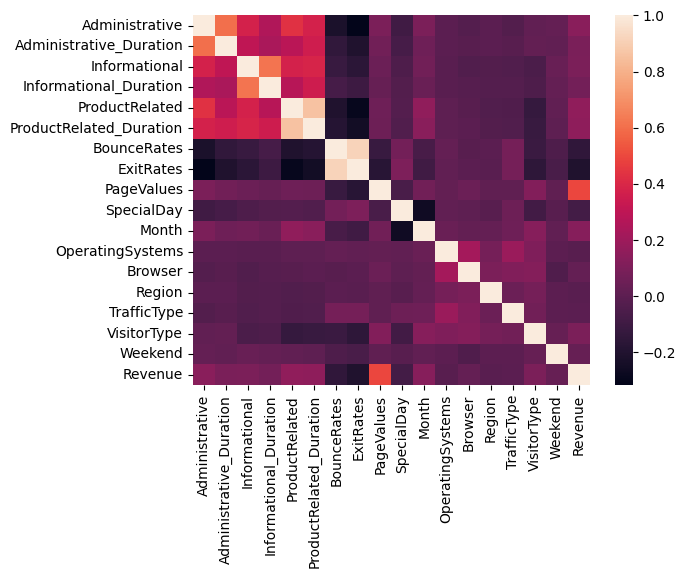

In [34]:
sns.heatmap(shopping_df.corr(numeric_only=True))

<Axes: >

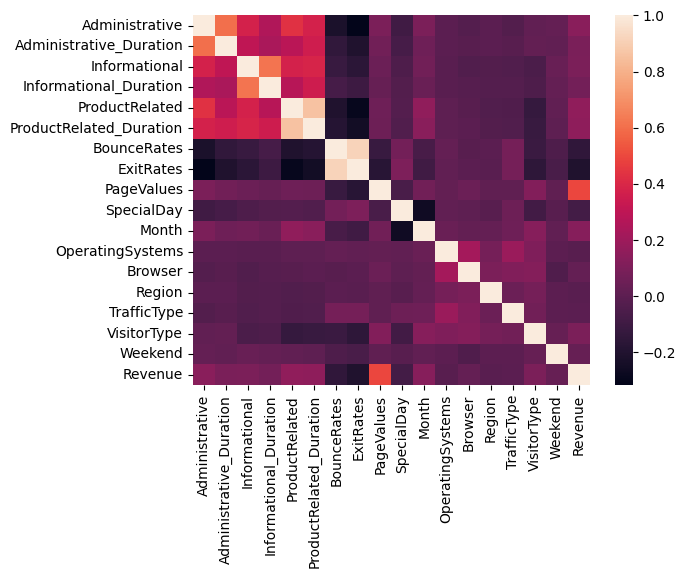

In [35]:
sns.heatmap(shopping_df.corr(method='pearson'))

<Axes: >

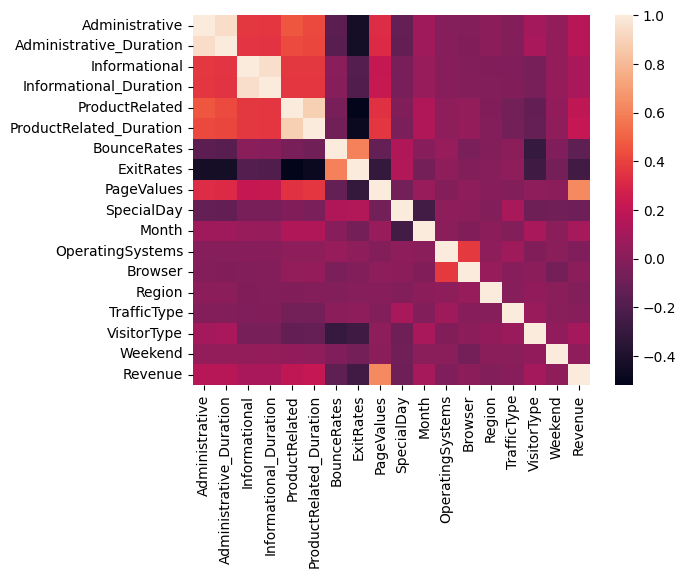

In [36]:
sns.heatmap(shopping_df.corr(method='spearman'))

In [ ]:
data_understanding_2b_code_writer = student_a

def data_understanding_2b():
    kurtosis_series = shopping_df.kurtosis(numeric_only=True)
    skew_series = shopping_df.skew(numeric_only=True)
    pearson_corr = shopping_df.corr(method="pearson", numeric_only=True)
    spearman_corr = shopping_df.corr(method="spearman", numeric_only=True)

    # --- Correlation heatmaps (saved to figures/) ---
    os.makedirs("figures", exist_ok=True)

    # Pearson heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pearson_corr, annot=False, vmin=-1, vmax=1)
    plt.title("Pearson Correlation Matrix")
    pearson_heatmap_path = os.path.join("figures", "corr_pearson.png")
    pearson_heatmap_path = pearson_heatmap_path.replace("\\", "/")
    plt.tight_layout()
    plt.savefig(pearson_heatmap_path, dpi=150)
    plt.close()

    # Spearman heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(spearman_corr, annot=False, vmin=-1, vmax=1)
    plt.title("Spearman Correlation Matrix")
    spearman_heatmap_path = os.path.join("figures", "corr_spearman.png")
    spearman_heatmap_path = spearman_heatmap_path.replace("\\", "/")
    plt.tight_layout()
    plt.savefig(spearman_heatmap_path, dpi=150)
    plt.close()

    results = {
        "kurtosis": kurtosis_series.to_dict(),
        "skewness": skew_series.to_dict(),
        "pearson_correlation": pearson_corr.to_dict(),
        "spearman_correlation": spearman_corr.to_dict(),
        "pearson_heatmap_path": pearson_heatmap_path,
        "spearman_heatmap_path": spearman_heatmap_path
    }

    return results


start_time_data_understanding_2b = now()
res_du = data_understanding_2b()
end_time_data_understanding_2b = now()


############################################################
# 2b Documentation (Provenance)
############################################################

data_understanding_2b_ass_uuid_executor = "512863f2-5fab-433f-a464-735d1696c53d" #generated, do not modify
data_understanding_2b_ass_uuid_writer = "233de42e-2c58-4341-bc6a-6457646e1731" #generated, do not modify

data_understanding_2b_comment = """
Data Understanding 2b: Statistical properties and correlations.
Kurtosis and skewness were computed for all numeric attributes, revealing heavy-tailed 
distributions in several duration and value-related features, and confirming class imbalance 
for the Revenue target. Pearson and Spearman correlation matrices were computed to identify 
linear and monotonic relationships between attributes. Correlations of each feature with 
Revenue were extracted, and correlation heatmaps were generated and saved for visual 
inspection..
"""

# Serialize numeric outputs for rdfs:comment (as JSON / text)
kurtosis_output = res_du["kurtosis"].to_json()
skew_output = res_du["skewness"].to_json()
pearson_corr_output = res_du["pearson_correlation"].to_json()
spearman_corr_output = res_du["spearman_correlation"].to_json()
pearson_corr_revenue_output = res_du["pearson_correlation"]["Revenue"].to_json()
spearman_corr_revenue_output = res_du["spearman_correlation"]["Revenue"].to_json()

kurtosis_conclusions = """
ProductRelated_Duration (137.17), PageValues (65.64), and Administrative_Duration (50.56) 
show extremely high kurtosis values, indicating very heavy-tailed distributions. This means 
that a small number of observations lie far from the mean and contribute disproportionately 
to the tails. These heavy tails suggest the presence of significant outliers, which will be 
checked in later steps of the analysis.
"""

skewness_conclusions = """
The attributes Month and Region show skewness values close to zero, suggesting nearly 
symmetric distributions. This supports the hypothesis that the dataset may be well-balanced 
across temporal and regional dimensions, with no major structural bias.

All duration-based attributes exhibit strongly positive skew, which is expected because they 
represent time spent on different page types and typically include many short visits and 
fewer long visits. These high-skew attributes will require special attention during outlier 
analysis.

The target variable Revenue is positively skewed, reflecting that purchases (Revenue = 1) 
are much less frequent than non-purchases. This confirms class imbalance in the dataset.
"""

# TODO: Difference between Pearson and Spearman

correlation_conclusions = """
Pearson and Spearman correlation matrices reveal expected positive correlations 
between page count and the Revenue target values. Correlations between other 
features and Revenue are generally modest. The two correlation heatmaps show
similar patterns, and matching scales.
"""

data_understanding_2b_activity = [
    # Activity definition
    ':data_understanding_2b rdf:type prov:Activity .',
    ':data_understanding_2b sc:isPartOf :data_understanding_phase .',
    ':data_understanding_2b rdfs:label "2b Statistical Properties and Correlations" .',
    f':data_understanding_2b rdfs:comment """{data_understanding_2b_comment}""" .',

    # Timing
    f':data_understanding_2b prov:startedAtTime "{start_time_data_understanding_2b}"^^xsd:dateTime .',
    f':data_understanding_2b prov:endedAtTime "{end_time_data_understanding_2b}"^^xsd:dateTime .',

    # Associations: executor
    f':data_understanding_2b prov:qualifiedAssociation :{data_understanding_2b_ass_uuid_executor} .',
    f':{data_understanding_2b_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{data_understanding_2b_ass_uuid_executor} rdf:type prov:Association .',
    f':{data_understanding_2b_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Associations: writer
    f':data_understanding_2b prov:qualifiedAssociation :{data_understanding_2b_ass_uuid_writer} .',
    f':{data_understanding_2b_ass_uuid_writer} prov:agent :{data_understanding_2b_code_writer} .',
    f':{data_understanding_2b_ass_uuid_writer} rdf:type prov:Association .',
    f':{data_understanding_2b_ass_uuid_writer} prov:hadRole :{code_writer_role} .',


    # === Entities: Kurtosis ===
    ':data_understanding_2b_kurtosis rdf:type prov:Entity .',
    ':data_understanding_2b_kurtosis rdfs:label "Kurtosis of Numeric Attributes" .',
    f':data_understanding_2b_kurtosis rdfs:comment """Kurtosis values (JSON): {kurtosis_output}\n\n{kurtosis_conclusions}""" .',
    ':data_understanding_2b_kurtosis prov:wasGeneratedBy :data_understanding_2b .',

    # === Entities: Skewness ===
    ':data_understanding_2b_skewness rdf:type prov:Entity .',
    ':data_understanding_2b_skewness rdfs:label "Skewness of Numeric Attributes" .',
    f':data_understanding_2b_skewness rdfs:comment """Skewness values (JSON): {skew_output}\n\n{skewness_conclusions}""" .',
    ':data_understanding_2b_skewness prov:wasGeneratedBy :data_understanding_2b .',


    # === Entities: Pearson Correlation Matrix ===
    ':data_understanding_2b_pearson_corr rdf:type prov:Entity .',
    ':data_understanding_2b_pearson_corr rdfs:label "Pearson Correlation Matrix" .',
    f':data_understanding_2b_pearson_corr rdfs:comment """Pearson correlation matrix (JSON): {pearson_corr_output}""" .',
    ':data_understanding_2b_pearson_corr prov:wasGeneratedBy :data_understanding_2b .',

    # === Entities: Spearman Correlation Matrix ===
    ':data_understanding_2b_spearman_corr rdf:type prov:Entity .',
    ':data_understanding_2b_spearman_corr rdfs:label "Spearman Correlation Matrix" .',
    f':data_understanding_2b_spearman_corr rdfs:comment """Spearman correlation matrix (JSON): {spearman_corr_output}""" .',
    ':data_understanding_2b_spearman_corr prov:wasGeneratedBy :data_understanding_2b .',

    # === Entity: High-level correlation interpretation ===
    ':data_understanding_2b_correlation_interpretation rdf:type prov:Entity .',
    ':data_understanding_2b_correlation_interpretation rdfs:label "2b Correlation Interpretation" .',
    f':data_understanding_2b_correlation_interpretation rdfs:comment """{correlation_conclusions}""" .',
    ':data_understanding_2b_correlation_interpretation prov:wasGeneratedBy :data_understanding_2b .',
]

# engine.insert(data_understanding_2b_activity, prefixes=prefixes)


Administrative               4.701146
Administrative_Duration     50.556739
Informational               26.932266
Informational_Duration      76.316853
ProductRelated              31.211707
ProductRelated_Duration    137.174164
BounceRates                  7.723159
ExitRates                    4.017035
PageValues                  65.635694
SpecialDay                   9.913659
Month                       -1.615746
OperatingSystems            10.456843
Browser                     12.746733
Region                      -0.148680
TrafficType                  3.479711
VisitorType                  4.544444
Weekend                     -0.397404
Revenue                      1.646493
dtype: float64

Administrative             1.960357
Administrative_Duration    5.615719
Informational              4.036464
Informational_Duration     7.579185
ProductRelated             4.341516
ProductRelated_Duration    7.263228
BounceRates                2.947855
ExitRates                  2.148789
PageValues                 6.382964
SpecialDay                 3.302667
Month                     -0.055407
OperatingSystems           2.066285
Browser                    3.242350
Region                     0.983549
TrafficType                1.962987
VisitorType                2.326762
Weekend                    1.265962
Revenue                    1.909509
dtype: float64

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
Administrative,1.000000,0.601583,0.376850,0.255848,0.431119,0.373939,-0.223563,-0.316483,0.098990,-0.094778,0.096713,-0.006347,-0.025035,-0.005487,-0.033561,0.016680,0.026417,0.138917
Administrative_Duration,0.601583,1.000000,0.302710,0.238031,0.289087,0.355422,-0.144170,-0.205798,0.067608,-0.073304,0.057885,-0.007343,-0.015392,-0.005561,-0.014376,0.019120,0.014990,0.093587
Informational,0.376850,0.302710,1.000000,0.618955,0.374164,0.387505,-0.116114,-0.163666,0.048632,-0.048219,0.063500,-0.009527,-0.038235,-0.029169,-0.034491,-0.058211,0.035785,0.095200
Informational_Duration,0.255848,0.238031,0.618955,1.000000,0.280046,0.347364,-0.074067,-0.105276,0.030861,-0.030577,0.044354,-0.009579,-0.019285,-0.027144,-0.024675,-0.045372,0.024078,0.070345
ProductRelated,0.431119,0.289087,0.374164,0.280046,1.000000,0.860927,-0.204578,-0.292526,0.056282,-0.023958,0.156022,0.004290,-0.013146,-0.038122,-0.043064,-0.127916,0.016092,0.158538
ProductRelated_Duration,0.373939,0.355422,0.387505,0.347364,0.860927,1.000000,-0.184541,-0.251984,0.052823,-0.036380,0.137520,0.002976,-0.007380,-0.033091,-0.036377,-0.118273,0.007311,0.152373
BounceRates,-0.223563,-0.144170,-0.116114,-0.074067,-0.204578,-0.184541,1.000000,0.913004,-0.119386,0.072702,-0.066562,0.023823,-0.015772,-0.006485,0.078286,-0.114916,-0.046514,-0.150673
ExitRates,-0.316483,-0.205798,-0.163666,-0.105276,-0.292526,-0.251984,0.913004,1.000000,-0.174498,0.102242,-0.095465,0.014567,-0.004442,-0.008907,0.078616,-0.152678,-0.062587,-0.207071
PageValues,0.098990,0.067608,0.048632,0.030861,0.056282,0.052823,-0.119386,-0.174498,1.000000,-0.063541,0.067198,0.018508,0.045592,0.011315,0.012532,0.120077,0.012002,0.492569
SpecialDay,-0.094778,-0.073304,-0.048219,-0.030577,-0.023958,-0.036380,0.072702,0.102242,-0.063541,1.000000,-0.256901,0.012652,0.003499,-0.016098,0.052301,-0.086854,-0.016767,-0.082305


Revenue                    1.000000
PageValues                 0.492569
ProductRelated             0.158538
ProductRelated_Duration    0.152373
Administrative             0.138917
Month                      0.127372
VisitorType                0.098485
Informational              0.095200
Administrative_Duration    0.093587
Informational_Duration     0.070345
Weekend                    0.029295
Browser                    0.023984
TrafficType               -0.005113
Region                    -0.011595
OperatingSystems          -0.014668
SpecialDay                -0.082305
BounceRates               -0.150673
ExitRates                 -0.207071
Name: Revenue, dtype: float64

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
Administrative,1.000000,0.940725,0.369194,0.362861,0.460204,0.421613,-0.155219,-0.434389,0.328350,-0.125391,0.080231,-0.004963,-0.012359,0.009413,-0.011739,0.094197,0.039527,0.167945
Administrative_Duration,0.940725,1.000000,0.357150,0.352060,0.430072,0.413765,-0.163609,-0.437912,0.317329,-0.131622,0.080856,-0.007425,-0.023003,0.018761,-0.015486,0.112920,0.042549,0.163960
Informational,0.369194,0.357150,1.000000,0.950958,0.368673,0.367522,0.005753,-0.185691,0.219471,-0.054115,0.058803,0.000017,-0.020386,-0.022920,-0.029061,-0.059110,0.043098,0.113876
Informational_Duration,0.362861,0.352060,0.950958,1.000000,0.361032,0.362720,-0.002474,-0.200056,0.223919,-0.054314,0.050753,0.003003,-0.013451,-0.015007,-0.026349,-0.053374,0.046284,0.112120
ProductRelated,0.460204,0.430072,0.368673,0.361032,1.000000,0.882672,-0.052305,-0.518920,0.341975,-0.021536,0.139682,0.021218,0.043554,-0.021400,-0.069877,-0.129735,0.034369,0.198545
ProductRelated_Duration,0.421613,0.413765,0.367522,0.362720,0.882672,1.000000,-0.079768,-0.476935,0.360282,-0.049578,0.134269,0.023485,0.045758,-0.009666,-0.072516,-0.119205,0.027364,0.216764
BounceRates,-0.155219,-0.163609,0.005753,-0.002474,-0.052305,-0.079768,1.000000,0.602276,-0.123726,0.135341,-0.003382,0.053448,-0.047057,-0.017960,0.015583,-0.303654,-0.032165,-0.148977
ExitRates,-0.434389,-0.437912,-0.185691,-0.200056,-0.518920,-0.476935,0.602276,1.000000,-0.308002,0.151278,-0.065578,0.022357,-0.016319,-0.003934,0.022440,-0.268306,-0.067640,-0.254488
PageValues,0.328350,0.317329,0.219471,0.223919,0.341975,0.360282,-0.123726,-0.308002,1.000000,-0.070480,0.061859,-0.012409,0.025728,0.001202,-0.017504,0.023391,0.020695,0.626363
SpecialDay,-0.125391,-0.131622,-0.054115,-0.054314,-0.021536,-0.049578,0.135341,0.151278,-0.070480,1.000000,-0.252287,0.022679,0.020734,-0.014977,0.110150,-0.093918,-0.074242,-0.086878


Revenue                    1.000000
PageValues                 0.626363
ProductRelated_Duration    0.216764
ProductRelated             0.198545
Administrative             0.167945
Administrative_Duration    0.163960
Informational              0.113876
Informational_Duration     0.112120
Month                      0.109443
VisitorType                0.103332
Weekend                    0.029295
Browser                    0.016234
TrafficType               -0.001189
Region                    -0.014792
OperatingSystems          -0.027330
SpecialDay                -0.086878
BounceRates               -0.148977
ExitRates                 -0.254488
Name: Revenue, dtype: float64

### 2.c. Data quality aspects
e.g. missing values and their potential effects and reasons, uneven distributions in certain attribute types, plausibility of values, outliers

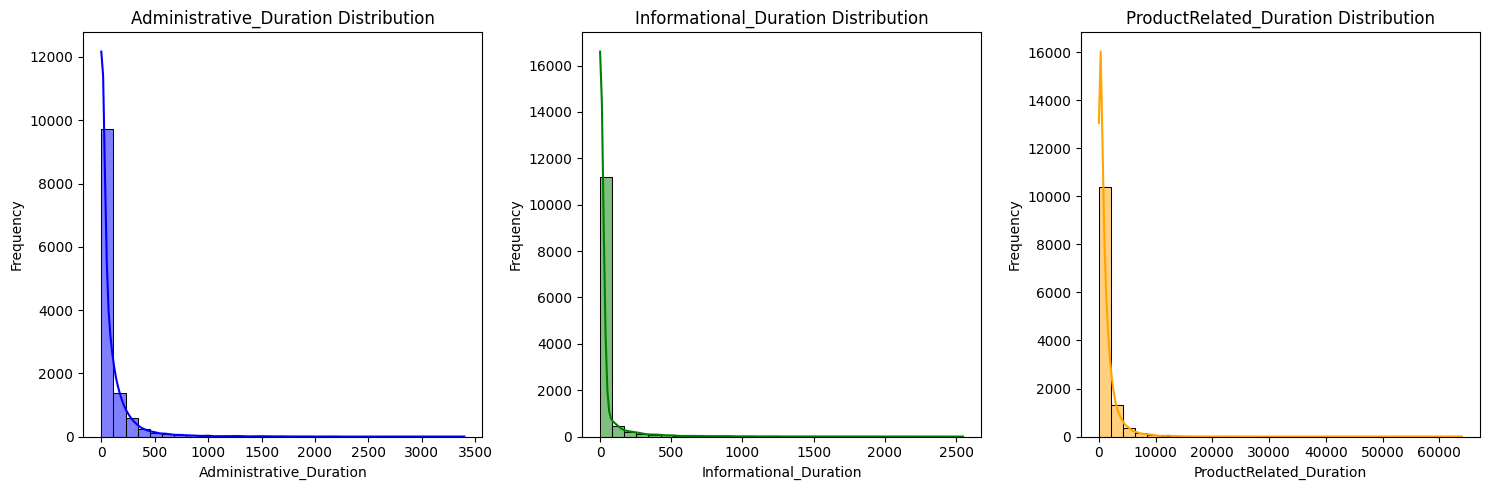

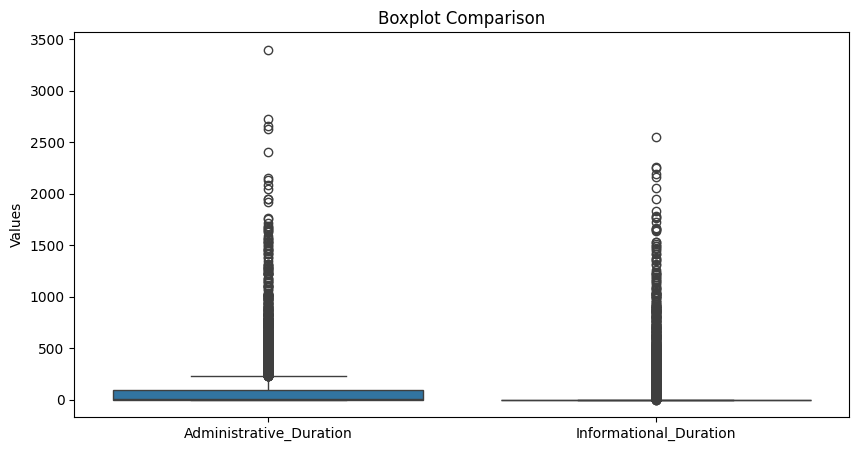

In [ ]:
# Compare distributions of Administrative_Duration, Informational_Duration, and ProductRelated_Duration
plt.figure(figsize=(15, 5))

# Histogram for Administrative_Duration
plt.subplot(1, 3, 1)
sns.histplot(shopping_df['Administrative_Duration'], kde=True, bins=30, color='blue')
plt.title('Administrative_Duration Distribution')
plt.xlabel('Administrative_Duration')
plt.ylabel('Frequency')

# Histogram for Informational_Duration
plt.subplot(1, 3, 2)
sns.histplot(shopping_df['Informational_Duration'], kde=True, bins=30, color='green')
plt.title('Informational_Duration Distribution')
plt.xlabel('Informational_Duration')
plt.ylabel('Frequency')

# Histogram for ProductRelated_Duration
plt.subplot(1, 3, 3)
sns.histplot(shopping_df['ProductRelated_Duration'], kde=True, bins=30, color='orange')
plt.title('ProductRelated_Duration Distribution')
plt.xlabel('ProductRelated_Duration')
plt.ylabel('Frequency')

plt.tight_layout()

# Save the plot to figures/durations_histogram
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/durations_histogram.png", dpi=150)
duration_distribution_output ="figures/durations_histogram.png"
plt.show()

# Boxplots for comparison
plt.figure(figsize=(10, 5))
sns.boxplot(data=shopping_df[['Administrative_Duration', 'Informational_Duration']])
plt.title('Boxplot Comparison')
plt.ylabel('Values')
plt.show()

## Conclusions
# The three duration attributes share the same units (seconds) and expected behavior, the data is significantly skewed with a few outlier values having extremely high values.

In [ ]:
# Exploring the outlier records

print("Administrative_Duration")
display(shopping_df['Administrative_Duration'].quantile([0.90, 0.95, 0.99, 0.999]))
display(shopping_df[(shopping_df["Administrative_Duration"] > 3000)])

print("Informational_Duration")
display(shopping_df['Informational_Duration'].quantile([0.90, 0.95, 0.99, 0.999]))
display(shopping_df[(shopping_df["Informational_Duration"] > 2200)])

print("ProductRelated_Duration")
display(shopping_df['ProductRelated_Duration'].quantile([0.90, 0.95, 0.99, 0.999]))
display(shopping_df[(shopping_df["ProductRelated_Duration"] > 30000)])


#shopping_df[(shopping_df["Administrative_Duration"] > 3000) | (shopping_df["Informational_Duration"] > 2000) | (shopping_df["ProductRelated_Duration"] > 50000)]

Administrative_Duration


0.900     224.887500
0.950     348.266369
0.990     830.587041
0.999    1759.738667
Name: Administrative_Duration, dtype: float64

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
8071,5,3398.75,6,2549.375,449,63973.52223,0.000764,0.027701,0.0,0.0,12,2,2,1,2,1,False,False


Informational_Duration


0.900      72.000000
0.950     195.000000
0.990     716.390000
0.999    1662.511434
Name: Informational_Duration, dtype: float64

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
6020,8,116.972222,9,2252.033333,19,1135.880556,0.009677,0.011842,0.0,0.0,7,3,2,4,2,1,True,False
8071,5,3398.750000,6,2549.375000,449,63973.522230,0.000764,0.027701,0.0,0.0,12,2,2,1,2,1,False,False
10302,4,367.000000,5,2256.916667,74,8981.580128,0.002989,0.043302,0.0,0.0,12,2,2,1,8,1,False,False


ProductRelated_Duration


0.900     2877.863333
0.950     4300.289077
0.990     8701.142697
0.999    17397.813506
Name: ProductRelated_Duration, dtype: float64

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
5152,17,2629.253968,24,2050.433333,705,43171.23338,0.004851,0.015431,0.763829,0.0,5,2,2,1,14,1,True,False
8071,5,3398.750000,6,2549.375000,449,63973.52223,0.000764,0.027701,0.000000,0.0,12,2,2,1,2,1,False,False


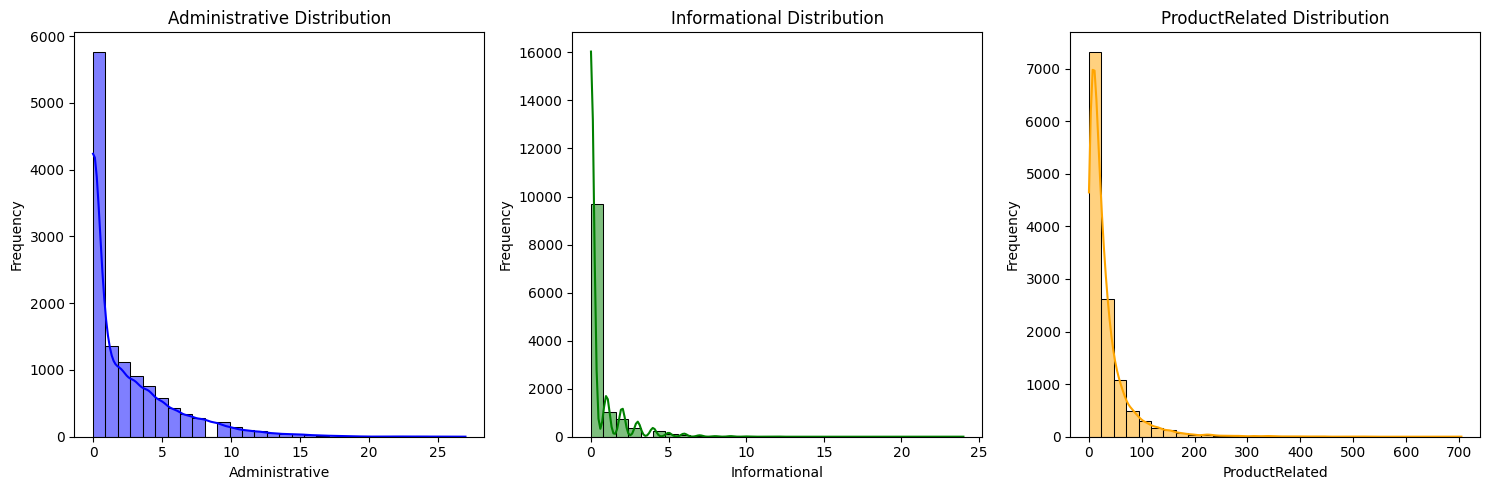

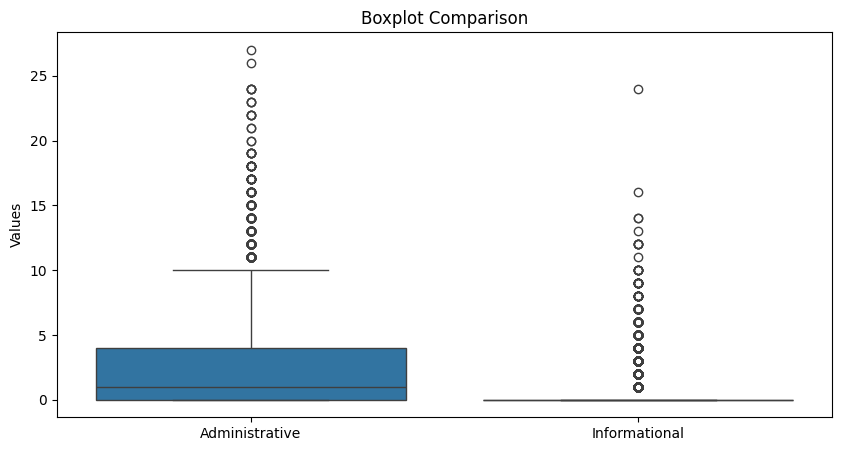

In [ ]:
# Compare distributions of Administrative, Informational, and ProductRelated pagevisit columns
plt.figure(figsize=(15, 5))

# Histogram for Administrative
plt.subplot(1, 3, 1)
sns.histplot(shopping_df['Administrative'], kde=True, bins=30, color='blue')
plt.title('Administrative Distribution')
plt.xlabel('Administrative')
plt.ylabel('Frequency')

# Histogram for Informational
plt.subplot(1, 3, 2)
sns.histplot(shopping_df['Informational'], kde=True, bins=30, color='green')
plt.title('Informational Distribution')
plt.xlabel('Informational')
plt.ylabel('Frequency')

# Histogram for ProductRelated
plt.subplot(1, 3, 3)
sns.histplot(shopping_df['ProductRelated'], kde=True, bins=30, color='orange')
plt.title('ProductRelated Distribution')
plt.xlabel('ProductRelated')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Save the plot to figures/pagevisits_histogram
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/pagevisits_histogram.png", dpi=150)
pagevisit_distribution_output ="figures/pagevisits_histogram.png"
plt.show()

# Boxplots for comparison
plt.figure(figsize=(10, 5))
sns.boxplot(data=shopping_df[['Administrative', 'Informational']])
plt.title('Boxplot Comparison')
plt.ylabel('Values')
plt.show()

# Boxplots for comparison
plt.figure(figsize=(10, 5))
sns.boxplot(data=shopping_df[['Administrative', 'Informational', 'ProductRelated']])
plt.title('Boxplot Comparison')
plt.ylabel('Values')
plt.show()

In [ ]:
# Exploring the outlier records

print("Administrative")
display(shopping_df['Administrative'].quantile([0.90, 0.95, 0.99, 0.999]))
display(shopping_df[(shopping_df["Administrative"] > 21)])

print("Informational")
display(shopping_df['Informational'].quantile([0.90, 0.95, 0.99, 0.999]))
display(shopping_df[(shopping_df["Informational"] > 20)])

print("ProductRelated")
display(shopping_df['ProductRelated'].quantile([0.90, 0.95, 0.99, 0.999]))
display(shopping_df[(shopping_df["ProductRelated"] > 600)])

outlier_records_output = shopping_df[(shopping_df["Administrative"] > 21) | (shopping_df["Informational"] > 20) | (shopping_df["ProductRelated"] > 600)]


Administrative


0.900     7.000
0.950     9.000
0.990    14.000
0.999    21.671
Name: Administrative, dtype: float64

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
1509,24,876.233333,5,625.500000,34,1588.666667,0.000000,0.013801,0.000000,0.0,3,2,2,5,2,1,False,False
2599,24,196.138592,1,28.000000,113,8699.407065,0.019308,0.047477,2.613453,0.0,5,2,2,6,11,1,True,False
4509,22,1951.279141,1,99.000000,55,3373.015865,0.016438,0.038293,8.508238,0.0,5,2,2,3,1,1,False,False
4937,24,290.860369,6,529.700000,178,4339.534423,0.003939,0.015263,6.149344,0.4,5,2,2,3,4,1,False,False
5597,24,468.100663,6,191.866667,189,3428.527381,0.018642,0.043831,0.870148,0.0,6,2,2,2,1,1,False,False
7504,23,335.130952,5,399.800000,88,1839.098106,0.015759,0.031588,0.000000,0.0,8,3,2,3,2,1,True,False
7828,23,239.744534,3,624.600000,409,9100.402959,0.004301,0.015935,6.277684,0.0,7,2,2,1,13,1,True,False
8308,27,853.735949,2,126.500000,584,24844.156200,0.002099,0.009347,4.511100,0.0,11,2,4,3,8,1,False,False
8349,22,438.330952,3,703.500000,178,6241.687398,0.002879,0.016886,2.038399,0.0,11,2,2,1,10,1,False,True
9078,23,322.941667,0,0.000000,62,3142.941176,0.003038,0.019685,7.311892,0.0,11,2,2,1,10,1,True,False


Informational


0.900     2.0
0.950     3.0
0.990     6.0
0.999    10.0
Name: Informational, dtype: float64

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
5152,17,2629.253968,24,2050.433333,705,43171.23338,0.004851,0.015431,0.763829,0.0,5,2,2,1,14,1,True,False


ProductRelated


0.900     74.00
0.950    109.00
0.990    221.00
0.999    435.71
Name: ProductRelated, dtype: float64

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
5152,17,2629.253968,24,2050.433333,705,43171.23338,0.004851,0.015431,0.763829,0.0,5,2,2,1,14,1,True,False
6684,20,199.456273,7,299.033333,686,23342.08205,0.009853,0.022771,0.150650,0.0,8,2,2,1,1,1,False,False


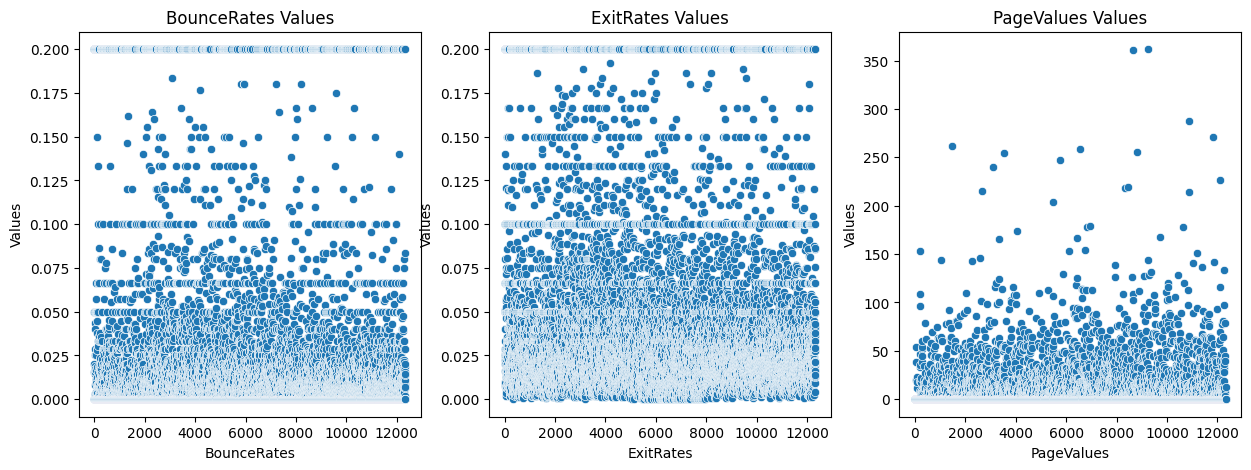

<Figure size 640x480 with 0 Axes>

In [ ]:
# Compare distributions of BounceRates, ExitRates, PageValues columns
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(shopping_df["BounceRates"])
plt.title('BounceRates Values')
plt.xlabel('BounceRates')
plt.ylabel('Values')

plt.subplot(1, 3, 2)
sns.scatterplot(shopping_df["ExitRates"])
plt.title('ExitRates Values')
plt.xlabel('ExitRates')
plt.ylabel('Values')

plt.subplot(1, 3, 3)
sns.scatterplot(shopping_df["PageValues"])
plt.title('PageValues Values')
plt.xlabel('PageValues')
plt.ylabel('Values')    

# Save the plot to figures/continous_values
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/continous_values.png", dpi=150)
continous_values_output ="figures/continous_values.png"
plt.show()

plt.tight_layout()
plt.show()


## CONCLUSIONS:
# - Administrative_Duration, Informational_Duration, and ProductRelated_Duration attributes are all continous numerical features for analytical metrics.
# To check any outliers, semantically errorous values, we checked the values itself. 
# The BounceRates and ExitRates has an upper limit of 0.2, and has an even distribution of below this threshold.
# These values should not be scaled, because their semantical meaning will be lost as these attributes express percentage values
# In the PageValues attributes, there are 2 records higher than 300, which we marked as outliers but there is no semantical error in these values.

In [18]:
# The outlier values for PageValues
shopping_df[shopping_df["PageValues"] > 350]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
8635,0,0.0,0,0.0,44,784.883333,0.0,0.004762,360.953384,0.0,12,8,13,9,20,3,False,True
9239,3,37.5,0,0.0,18,607.500000,0.0,0.010526,361.763742,0.0,11,2,2,3,2,2,False,True


In [23]:
shopping_df["OperatingSystems"].value_counts()

OperatingSystems
2    6601
1    2585
3    2555
4     478
8      79
6      19
7       7
5       6
Name: count, dtype: int64

In [24]:
shopping_df["Browser"].value_counts()

Browser
2     7961
1     2462
4      736
5      467
6      174
10     163
8      135
3      105
13      61
7       49
12      10
11       6
9        1
Name: count, dtype: int64

In [25]:
shopping_df["Region"].value_counts()

Region
1    4780
3    2403
4    1182
2    1136
6     805
7     761
9     511
8     434
5     318
Name: count, dtype: int64

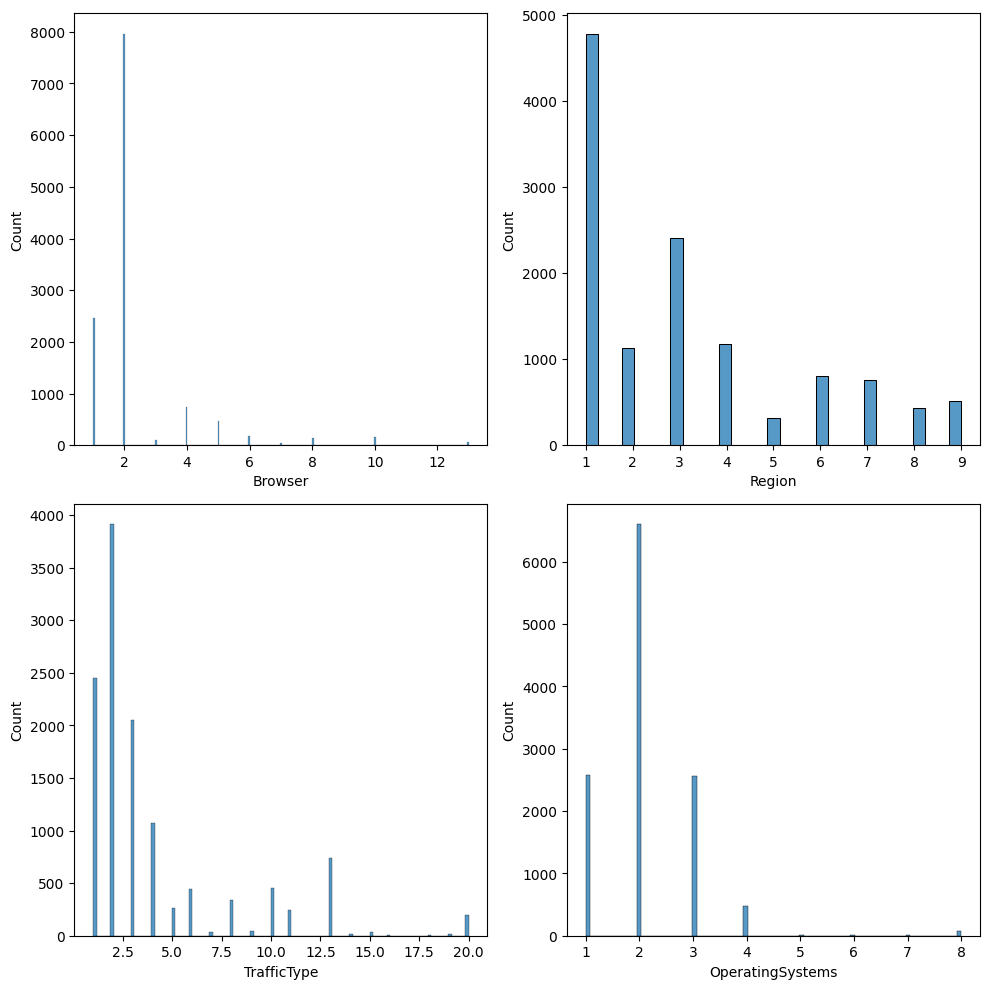

In [ ]:
# Distributions of categorical attributes
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.histplot(shopping_df["Browser"])

plt.subplot(2, 2, 2)
sns.histplot(shopping_df["Region"])

plt.subplot(2, 2, 3)
sns.histplot(shopping_df["TrafficType"])

plt.subplot(2, 2, 4)
sns.histplot(shopping_df["OperatingSystems"])

# Save the plot to figures/categorical_distributions
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/categorical_distributions.png", dpi=150)

categorical_distribution_output ="figures/categorical_distributions.png"

plt.tight_layout()
plt.show()


In [ ]:
# VisitorType distribution

visitortype_distribution_output = pd.concat(
    [shopping_df["VisitorType"].value_counts(normalize=False), 
     shopping_df["VisitorType"].value_counts(normalize=True)],
    axis=1,
    keys=["Count", "Proportion"]))

display(visitortype_distribution_output)
## CONCLUSIONS
# Even though the official provenance described the attribute as a two-class label, there are 85 "other" categories.

,Count,Proportion
VisitorType,,
1,10551,0.855718
2,1694,0.137388
3,85,0.006894


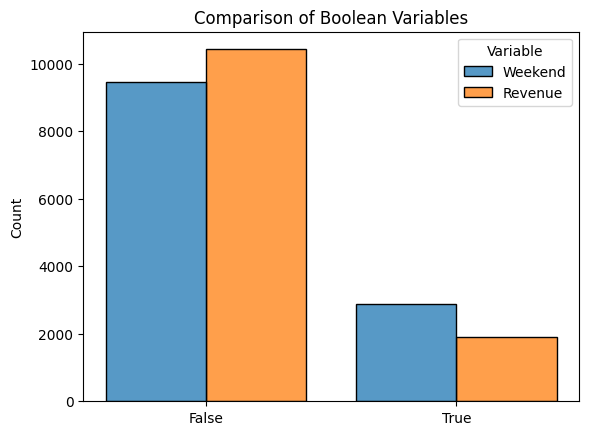

In [ ]:
# Compare Weekend vs Revenue distributions (both boolean)
bool_long = shopping_df[['Weekend', 'Revenue']].melt(
    var_name='Variable', value_name='Boolean_Value'
)
bool_long['Boolean_Value'] = bool_long['Boolean_Value'].astype(int)

ax = sns.histplot(
    data=bool_long,
    x='Boolean_Value',
    hue='Variable',
    multiple='dodge',
    shrink=0.8,
    discrete=True
)

# Refine the axis labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['False', 'True'])
ax.set_xlabel('')
ax.set_title('Comparison of Boolean Variables')


# Save the plot to figures/binary_distribution
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/binary_distribution.png", dpi=150)
binary_distribution_output ="figures/binary_distribution.png"
plt.show()


## CONCLUSION:
# - Both Weekend and Revenue are boolean attributes. The Revenue attribute is highly imbalanced, with many more False than True values.
# The Weekend attribute is close to its natural distribution, as 2/7 = 28.57% of a calendar year is weekend.

In [ ]:
# Group by Month and calculate proportions of Weekend (True vs False)
weekend_distribution_output = shopping_df.groupby('Month')['Weekend'].value_counts(normalize=True).unstack()

# Display the proportions
display(weekend_distribution_output)

## CONCLUSION
# Although the weekend attribute is imbalanced, its distribution is relatively consistent across months, ranging from approximately 15% to 25% weekend each month.

Weekend,False,True
Month,,
2,0.847826,0.152174
3,0.747771,0.252229
5,0.787455,0.212545
6,0.836806,0.163194
7,0.759259,0.240741
8,0.778291,0.221709
9,0.785714,0.214286
10,0.737705,0.262295
11,0.736157,0.263843


In [40]:
def check_outliers(df: pd.DataFrame, threshold=3.0, columns: list = None) -> dict:
    results = {}

    for col in columns:
        values = df[col].astype(float)

        mean = values.mean()
        std = values.std()

        if std == 0 or np.isnan(std):
            results[col] = []
            continue

        z_scores = (values - mean) / std

        mask = np.abs(z_scores) > threshold
        outliers = values[mask].index

        outlier_info = [
            {
                'index': int(idx),
                'z_score': float(z_scores.loc[idx])
            }
            for idx in outliers
        ]

        results[col] = outlier_info

    return results


In [ ]:
data_understanding_2c_code_writer = student_a

def data_understanding_2c():
    check_outliers(shopping_df, threshold=10.0, columns = ["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration", "BounceRates", "ExitRates", "PageValues"])


start_time_data_understanding_2c = now()
outliers_report = data_understanding_2c()
end_time_data_understanding_2c = now()


############################################################
# 2c Documentation (Provenance)
############################################################

data_understanding_2c_ass_uuid_executor = "153ad75c-19b9-4862-abd7-7470e84cd5c3" #generated, do not modify
data_understanding_2c_ass_uuid_writer   = "198161c2-7428-4445-9c76-092123e9659a" #generated, do not modify

data_understanding_2c_comment = """
Data Understanding 2c: Assessment of data quality including missing values, plausibility, 
outliers, and imbalance of numerical and categorical attributes.
This step performs systematic data quality checks to support later preprocessing decisions.
"""

duration_distributions_comment = """
The three duration attributes share the same units (seconds) and expected behavior, the data is significantly skewed with a few outlier values having extremely high values.
"""

pagevisit_distributions_comment = """
The related discreate attributes of visited pages show the same conclusion.
"""


data_understanding_2c_activity = [

    # Activity Definition
    ':data_understanding_2c rdf:type prov:Activity .',
    ':data_understanding_2c sc:isPartOf :data_understanding_phase .',
    ':data_understanding_2c rdfs:label "2c Data Quality Analysis" .',
    f':data_understanding_2c rdfs:comment """{data_understanding_2c_comment}""" .',

    # Timing
    f':data_understanding_2c prov:startedAtTime "{start_time_data_understanding_2c}"^^xsd:dateTime .',
    f':data_understanding_2c prov:endedAtTime "{end_time_data_understanding_2c}"^^xsd:dateTime .',

    # Associations: executor
    f':data_understanding_2c prov:qualifiedAssociation :{data_understanding_2c_ass_uuid_executor} .',
    f':{data_understanding_2c_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{data_understanding_2c_ass_uuid_executor} rdf:type prov:Association .',
    f':{data_understanding_2c_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Associations: writer
    f':data_understanding_2c prov:qualifiedAssociation :{data_understanding_2c_ass_uuid_writer} .',
    f':{data_understanding_2c_ass_uuid_writer} prov:agent :{data_understanding_2c_code_writer} .',
    f':{data_understanding_2c_ass_uuid_writer} rdf:type prov:Association .',
    f':{data_understanding_2c_ass_uuid_writer} prov:hadRole :{code_writer_role} .',


    # === Entity: Duration Distributions ===
    f':data_understanding_2c_duration_distributions rdf:type prov:Entity .',
    f':data_understanding_2c_duration_distributions rdfs:label "Compare Distributions of Duration Attributes" .',
    f':data_understanding_2c_duration_distributions rdfs:comment """Distribution of the duration attributes: {duration_distribution_output}\n\n{duration_distributions_comment}""" .',
    f':data_understanding_2c_duration_distributions prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: Outlier Records ===
    f':data_understanding_2c_outlier_records rdf:type prov:Entity .',
    f':data_understanding_2c_outlier_records rdfs:label "Outlier Records" .',
    f':data_understanding_2c_outlier_records rdfs:comment """Outlier records output: {outlier_records_output}\n\n{outlier_records_comment}""" .',
    f':data_understanding_2c_outlier_records prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: Distributions of Continuous Attributes ===
    f':data_understanding_2c_continuous_distributions rdf:type prov:Entity .',
    f':data_understanding_2c_continuous_distributions rdfs:label "Distributions of Continuous Attributes" .',
    f':data_understanding_2c_continuous_distributions rdfs:comment """Continuous distributions output: {continuous_values_output}\n\n{continuous_distributions_comment}""" .',
    f':data_understanding_2c_continuous_distributions prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: Distributions of Categorical Attributes ===
    f':data_understanding_2c_categorical_distributions rdf:type prov:Entity .',
    f':data_understanding_2c_categorical_distributions rdfs:label "Distributions of Categorical Attributes" .',
    f':data_understanding_2c_categorical_distributions rdfs:comment """Categorical distributions output: {categorical_distributions_output}\n\n{categorical_distributions_comment}""" .',
    f':data_understanding_2c_categorical_distributions prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: VisitorType Distribution ===
    f':data_understanding_2c_visitortype_distribution rdf:type prov:Entity .',
    f':data_understanding_2c_visitortype_distribution rdfs:label "VisitorType Distribution" .',
    f':data_understanding_2c_visitortype_distribution rdfs:comment """VisitorType distribution output: {visitortype_distribution_output}\n\n{visitortype_distribution_comment}""" .',
    f':data_understanding_2c_visitortype_distribution prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: Binary Values ===
    f':data_understanding_2c_binary_values rdf:type prov:Entity .',
    f':data_understanding_2c_binary_values rdfs:label "Binary Values" .',
    f':data_understanding_2c_binary_values rdfs:comment """Binary values output: {binary_distribution_output}\n\n{binary_values_comment}""" .',
    f':data_understanding_2c_binary_values prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: Weekend Distribution ===
    f':data_understanding_2c_weekend_distribution rdf:type prov:Entity .',
    f':data_understanding_2c_weekend_distribution rdfs:label "Weekend Distribution" .',
    f':data_understanding_2c_weekend_distribution rdfs:comment """Weekend distribution output: {weekend_distribution_output}\n\n{weekend_distribution_comment}""" .',
    f':data_understanding_2c_weekend_distribution prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: Z-score Outliers ===
    f':data_understanding_2c_zscore_outliers rdf:type prov:Entity .',
    f':data_understanding_2c_zscore_outliers rdfs:label "Z-score Outliers" .',
    f':data_understanding_2c_zscore_outliers rdfs:comment """Z-score outliers output: {outliers_report}\n\n{zscore_outliers_comment}""" .',
    f':data_understanding_2c_zscore_outliers prov:wasGeneratedBy :data_understanding_2c .',

]

# engine.insert(data_understanding_2c_activity, prefixes=prefixes)


### 2.d Visual exploration of data properties and hypotheses

In [42]:
str(uuid.uuid4())

'198161c2-7428-4445-9c76-092123e9659a'

### 2.e Sensitive data
Evaluate and document whether the data set contains attributes that are potentially ethically sensitive, minority classes or underrepresented data groups, unbalanced distributions with respect to bias (to guide over- and under-sampling, micro- and macro evaluation criteria)

In [ ]:
data_understanding_2e_ass_uuid_executor = "ab8b679b-9d9a-4220-aa40-27b35ac6d953" #generated, do not modify


data_understanding_2e_comment = """
...
"""


data_understanding_2e_activity = [
    # Activity definition
    ':data_understanding_2e rdf:type prov:Activity .',
    ':data_understanding_2e sc:isPartOf :data_understanding_phase .',
    ':data_understanding_2e rdfs:label "2e Sensitive data" .',
    f':data_understanding_2e rdfs:comment """{data_understanding_2e_comment}""" .',


    # Associations: executor
    f':data_understanding_2e prov:qualifiedAssociation :{data_understanding_2e_ass_uuid_executor} .',
    f':{data_understanding_2e_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{data_understanding_2e_ass_uuid_executor} rdf:type prov:Association .',
    f':{data_understanding_2e_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

]

# engine.insert(data_understanding_2e_activity, prefixes=prefixes)

### 2.f Potential risk and bias
What potential risks and additional types of bias exist in the data? What questions would you need to have answered by an external expert in order to determine potential bias or data quality issues?


In [ ]:
data_understanding_2f_ass_uuid_executor = "fb246012-e80d-4335-8d7e-5992f4ef9ac3" #generated, do not modify


data_understanding_2f_comment = """
...
"""


data_understanding_2f_activity = [
    # Activity definition
    ':data_understanding_2f rdf:type prov:Activity .',
    ':data_understanding_2f sc:isPartOf :data_understanding_phase .',
    ':data_understanding_2f rdfs:label "2f Potential risk and bias" .',
    f':data_understanding_2f rdfs:comment """{data_understanding_2f_comment}""" .',


    # Associations: executor
    f':data_understanding_2f prov:qualifiedAssociation :{data_understanding_2f_ass_uuid_executor} .',
    f':{data_understanding_2f_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{data_understanding_2f_ass_uuid_executor} rdf:type prov:Association .',
    f':{data_understanding_2f_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

]

# engine.insert(data_understanding_2f_activity, prefixes=prefixes)

### 2.g Which actions are likely required in data preparation based on this analysis?

In [ ]:
data_understanding_2g_ass_uuid_executor = "1e1da868-fe9a-45d5-b693-f3d27a7e656e" #generated, do not modify


data_understanding_2g_comment = """
...
"""


data_understanding_2g_activity = [
    # Activity definition
    ':data_understanding_2g rdf:type prov:Activity .',
    ':data_understanding_2g sc:isPartOf :data_understanding_phase .',
    ':data_understanding_2g rdfs:label "2g Likely actions" .',
    f':data_understanding_2g rdfs:comment """{data_understanding_2g_comment}""" .',


    # Associations: executor
    f':data_understanding_2g prov:qualifiedAssociation :{data_understanding_2g_ass_uuid_executor} .',
    f':{data_understanding_2g_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{data_understanding_2g_ass_uuid_executor} rdf:type prov:Association .',
    f':{data_understanding_2g_ass_uuid_executor} prov:hadRole :{code_executor_role} .',


]

# engine.insert(data_understanding_2g_activity, prefixes=prefixes)


## Data Preparation

In [ ]:
# For UUID generation, only once for each activity
str(uuid.uuid4())

In [ ]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
# engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [ ]:
handle_outliers_code_writer = student_b
def handle_outliers(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    # REMOVE OUTLIERS
    # ...
    return df

start_time_td = now()
handle_outliers(data, outliers_report)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "" # To generate later
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
# engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "" # To generate later
td_comment = """
Removing all outliers that were identifying in the Data Understanding Phase.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
# engine.insert(handle_outliers_activity, prefixes=prefixes)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [ ]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data rdf:type sc:Dataset .',
    # ....
]
# engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [ ]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
# engine.insert(modeling_phase_executor, prefixes=prefixes)


In [ ]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "" # To generate later
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    
    # you can also define your Evaluation Measures here
    
    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

    
]
# engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [ ]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "" # To generate later
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters
    
]
# engine.insert(identify_hp_activity, prefixes=prefixes)

In [ ]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "" # To generate later
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .', 

    
]
# engine.insert(define_split_activity, prefixes=prefixes)

In [ ]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "" # To generate later
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .', 
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',     
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
# engine.insert(train_model_activity, prefixes=prefixes)


In [ ]:
def retrain_model_full_data(training_set, validation_set):
    
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "" # To generate later

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
# engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [ ]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
# engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [ ]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "" # To generate later
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
# engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [ ]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
# engine.insert(deployment_phase_executor, prefixes=prefixes)

In [ ]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "" # To generate later
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
# engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
# engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [50]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}"


In [42]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [ ]:
## TEST if the server is working

q = f"""
{prefix_header}
SELECT ?p ?o
WHERE {{
  :data_understanding_phase ?p ?o .
}}
"""
display(engine.query(q))


In [45]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

Data extraction done.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [46]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [47]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data\report\experiment_report.tex
